## Keras CNN Exploration

### Load Libraries

In [1]:
import sys
import os
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
import warnings 
warnings.filterwarnings('ignore', category=UserWarning)
sys.path.insert(0, '../../')
from library.notebook_api.data_loader import  ModelDataLoader,CombinedDataLoader
from library.notebook_api.model_loader import ModelScenario

2024-11-16 09:41:09.404094: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Data
load data from data loader and inspect the shape of the features which appears to be variable

In [2]:
model_data_loader = ModelDataLoader('005')
model_data_loader_df = model_data_loader.df
features = model_data_loader.get_mfcc()
labels_series = model_data_loader.df['label']
#array of feature shapes
feature_shapes = [feature.shape[1] for feature in features]
print("features shape distribution")
print(pd.Series(feature_shapes).value_counts())
print("total records: ", len(features))

features shape distribution
2582    13227
2585    10274
2812      522
1         472
1291      141
        ...  
761         1
2601        1
1584        1
2025        1
2542        1
Name: count, Length: 106, dtype: int64
total records:  24878


In [4]:
#verify matching length
len(labels_series) , len(features)

(24878, 24878)

### Define Filter Based on features

In [5]:
# currently filtered to just the most common shapes, as we'll need to normalize shapes prior to training 
MFCC_LENGTH_CUTOFF = 2582
#array of indexes matching a predicate 
in_scope_feature_indexes = np.where(np.array(feature_shapes) >= MFCC_LENGTH_CUTOFF)[0]
print("normalized length: ",len(in_scope_feature_indexes))

normalized length:  24029


### Define filter based on labels

In [6]:
#pick subset of labels that are more intuitively representative of genre 
#genres like pop which are ambiguous are removed 
in_scope_labels = ['rock', 'electronic', 'hiphop', 'classical', 'jazz','country']
#optain the indexes of label series wher the label is in the list 
in_scope_label_indexes = np.array(
    (labels_series[
                    labels_series
                        .apply(lambda x: True if x in  in_scope_labels else False)
                ]
                        .index
    )
)

#combine filter for the in scope labels with the same for in scope features 
in_scope_indexes = [index for index in in_scope_label_indexes if index in in_scope_feature_indexes]

print("Row Count after label based filter: ", len(in_scope_label_indexes))
print("Final Row count after label and feature filter: ", len(in_scope_indexes))

Row Count after label based filter:  15074
Final Row count after label and feature filter:  14557


### Encode Labels
assign a numerical index to each string label, then one hot encode the label dataset 

In [9]:
in_scope_label_series = labels_series.iloc[in_scope_indexes]
unique_label_names = in_scope_label_series.unique()
unique_label_count = len(in_scope_label_series.unique())
label_to_int_map = {}
for index, label in enumerate(unique_label_names):
    label_to_int_map[label] = index  

#numerical_labels = labels_series.map(label_to_int_map)
numerical_labels = in_scope_label_series.map(label_to_int_map)

encoded_labels = tf.one_hot(indices = numerical_labels.values, depth = len(unique_label_names))

#put to list and reshape again 
#not needed in current implementation
#encoded_labels_array = [label.reshape((unique_label_count,1)) for label in encoded_labels.numpy()]
print("Unique label count: ", unique_label_count)
print("label data count " , len(encoded_labels))

Unique label count:  6
label data count  14557


### filter, truncate, reshape features
iterate through the filtered features and build a vector representation appropriate for the CNN input

In [10]:
#truncate to consistent length while reshaping 
reshaped_features = []
for feature in features[in_scope_indexes]:
    mfcc = [] 
    for vector in feature: 
        mfcc.append(vector[0:MFCC_LENGTH_CUTOFF])
        mfcc_reshaped = np.array(mfcc)
    reshaped_features.append(mfcc_reshaped.reshape((MFCC_LENGTH_CUTOFF,13,1)))

### Train Test Split

In [11]:
#generate train and test with stratification for equal label distribution across train and test 
TEST_SIZE = .2
X_train, X_test, y_train, y_test = train_test_split(np.array(reshaped_features), encoded_labels.numpy(), test_size=TEST_SIZE, random_state=42, stratify =encoded_labels.numpy() )

In [12]:
#inspect shapes
X_train.shape, y_train.shape

((11645, 2582, 13, 1), (11645, 6))

### Define CNN model

In [13]:
model = keras.Sequential(layers=[
    #https://www.youtube.com/watch?v=dOG-HxpbMSw
    #convulution 1
    keras.layers.Conv2D(32, (3,3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    #convolution 2
    keras.layers.Conv2D(32, (3,3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    #convolution 3
    keras.layers.Conv2D(32, (2,2), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    #flatten and feed into dense layer with dropiut
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dropout(0.3),
    #predictions
    keras.layers.Dense(unique_label_count, activation=keras.activations.softmax)
        
    ])
cce = keras.losses.categorical_crossentropy

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=cce, metrics=['accuracy'])

In [22]:
#note this currently only works after training
#To do figure out how to build model prior to training to inspect it's architectuer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2580, 11, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 1290, 6, 32)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 1290, 6, 32)       128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 1288, 4, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 644, 2, 32)        0         
 g2D)                                                            
                                                        

### Train Model

In [19]:
#configuration
BATCH_SIZE = 128
#BATCH_SIZE = 64
#BATCH_SIZE = 32
#EPOCHS = 50
EPOCHS = 6
EPOCHS = 200

Epoch 1/200
73/73 [==============================] - 107s 1s/step - loss: 1.1009 - accuracy: 0.5509 - val_loss: 1.2629 - val_accuracy: 0.5187
Epoch 2/200
73/73 [==============================] - 114s 2s/step - loss: 1.0717 - accuracy: 0.5627 - val_loss: 1.2681 - val_accuracy: 0.5122
Epoch 3/200
73/73 [==============================] - 108s 1s/step - loss: 1.0488 - accuracy: 0.5765 - val_loss: 1.2739 - val_accuracy: 0.5204
Epoch 4/200
73/73 [==============================] - 106s 1s/step - loss: 1.0096 - accuracy: 0.5832 - val_loss: 1.2848 - val_accuracy: 0.5118
Epoch 5/200
73/73 [==============================] - 104s 1s/step - loss: 0.9810 - accuracy: 0.6011 - val_loss: 1.2994 - val_accuracy: 0.5079
Epoch 6/200
73/73 [==============================] - 104s 1s/step - loss: 0.9368 - accuracy: 0.6141 - val_loss: 1.3105 - val_accuracy: 0.5028


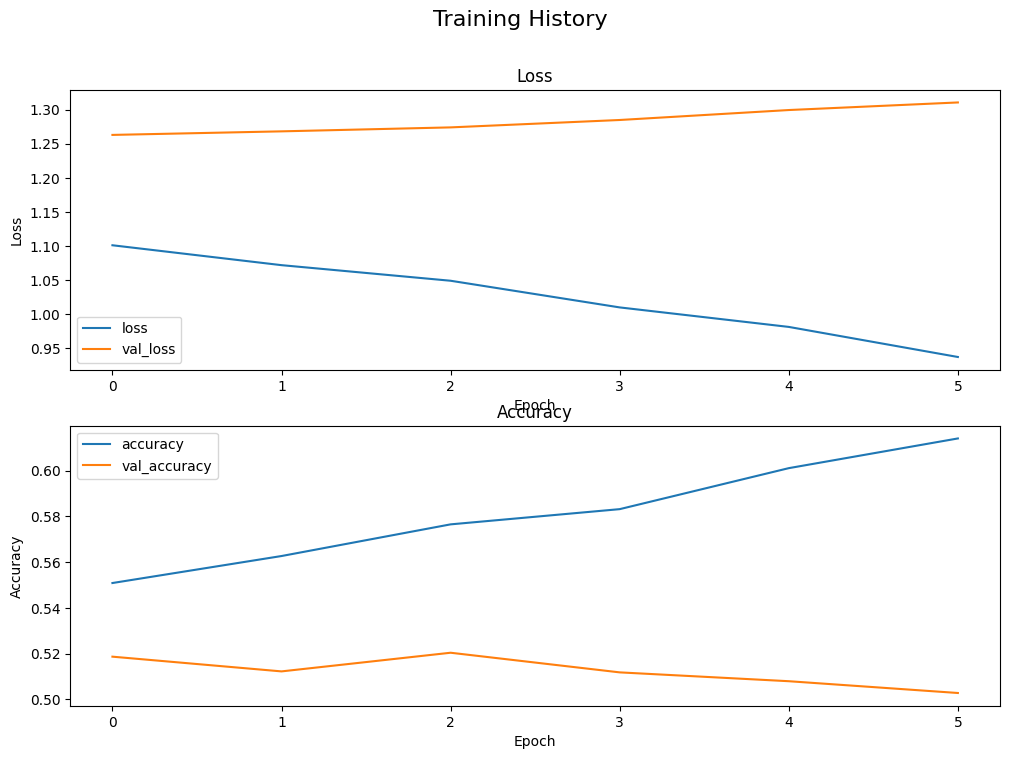

In [20]:
# Train the model
#following reference: https://www.kaggle.com/code/nilshmeier/melspectrogram-based-cnn-classification/notebook
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    #monitor='val_accuracy',
    min_delta = 0,
    patience=5, 
    mode='auto',
    restore_best_weights=True
    )
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

91/91 [==============================] - 13s 137ms/step


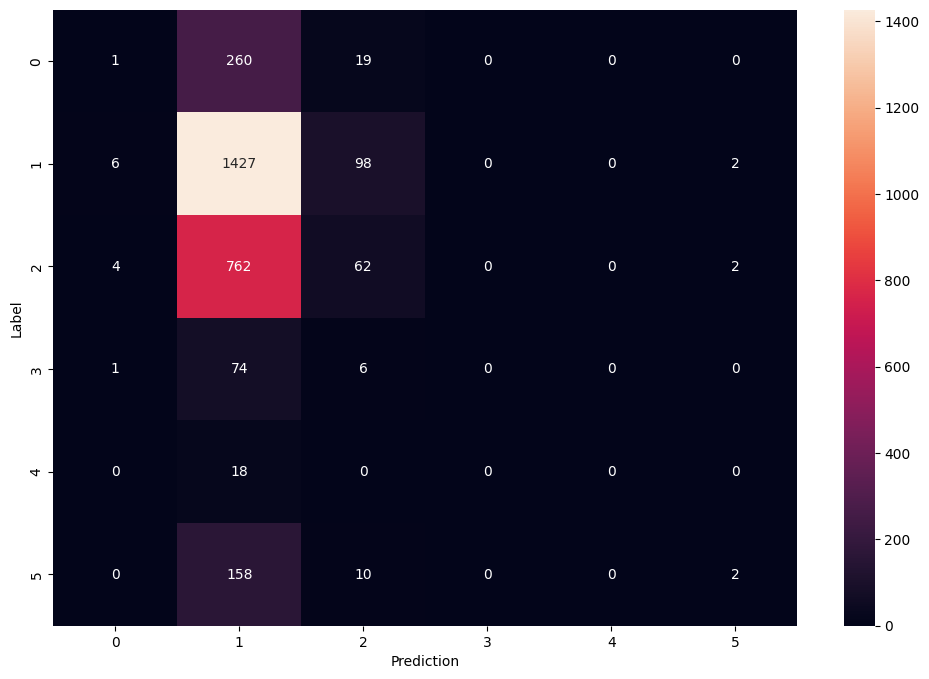

In [21]:
#validation 
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(numerical_labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()